# Liberías

In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import plotly.express as px
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

# Carga de datos

In [31]:
archivo = "data/gen/cleaned.csv"
df = pd.read_csv(archivo)
df.head()

,ANO_EMISION,MES_EMISION,DIA_EMISION,DEPTO_MCPIO,QUIEN_REPORTA,VIC_SEXO,VIC_EDAD,TOTAL_HIJOS,NUM_HIJ_HOM,NUM_HIJ_MUJ,...,AGR_TRABAJA,AGR_DEDICA,AGRESORES_OTROS_TOTAL,AGR_OTROS_HOM,AGR_OTRAS_MUJ,AGR_OTROS_N_OS,AGR_OTRAS_N_AS,INST_DENUN_HECHO,LEY_APLICABLE,FECHA_EMISION
0,2013,1,22,guatemala,Víctima,Mujeres,38.0,2,1,1,...,Si,Ocupaciones ignoradas,0,0.0,0.0,0.0,0.0,Organismo Judicial,Ambas leyes (VIF y VCM),2013-01-22
1,2013,1,24,guatemala,Víctima,Mujeres,20.0,1,0,1,...,Si,Trabajadores ambulantes de servicios y afines,99,99.0,99.0,99.0,99.0,Ministerio Público,NaN,2013-01-24
2,2013,1,21,guatemala,Víctima,Mujeres,21.0,2,1,1,...,Si,Albañiles,99,99.0,99.0,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-21
3,2013,1,2,guatemala,Víctima,Hombres,70.0,0,0,0,...,No,Quehaceres del Hogar,99,99.0,99.0,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-02
4,2013,1,10,guatemala,Víctima,Mujeres,36.0,99,99,99,...,Si,Ocupaciones no especificadas en las anteriores,99,99.0,99.0,99.0,99.0,Procuraduría de los Derechos Humanos,NaN,2013-01-10


# Variables de interés

In [32]:
victimaDf = df[["VIC_SEXO", "VIC_EDAD", "TOTAL_HIJOS", "VIC_ALFAB", "VIC_ESCOLARIDAD", "VIC_EST_CIV", "VIC_GRUPET", "VIC_TRABAJA", "VIC_DEDICA" ,"VIC_DISC"]]
victimaDf.head()

,VIC_SEXO,VIC_EDAD,TOTAL_HIJOS,VIC_ALFAB,VIC_ESCOLARIDAD,VIC_EST_CIV,VIC_GRUPET,VIC_TRABAJA,VIC_DEDICA,VIC_DISC
0,Mujeres,38.0,2,Si,49.0,Casados(as),Ladinos(as),Si,Secretarios (general),No
1,Mujeres,20.0,1,Si,31.0,Unidos(as),Ladinos(as),Si,Asistentes de venta de tiendas y almacenes,No
2,Mujeres,21.0,2,Si,29.0,Solteros(as),Maya,No,Quehaceres del hogar,No
3,Hombres,70.0,0,Si,49.0,Casados(as),Ladinos(as),No,Vive de sus renta o jubilación,No
4,Mujeres,36.0,99,Si,59.0,Casados(as),Ladinos(as),Si,Directores generales y gerentes generales,No


# Preprocesamiento

In [33]:
categorical_features = victimaDf.select_dtypes(exclude=['number']).columns
numeric_features = victimaDf.select_dtypes(include=['number']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

victima_preprocessed = preprocessor.fit_transform(victimaDf)

# Clustering

In [34]:
# Definir número de clústeres aleatorio (k)
k = 5

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(victima_preprocessed)
clusters = kmeans.labels_

victimaDf['cluster'] = clusters

C:\Users\ealva\AppData\Local\Temp\ipykernel_1940\1154386362.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Visualización con PCA

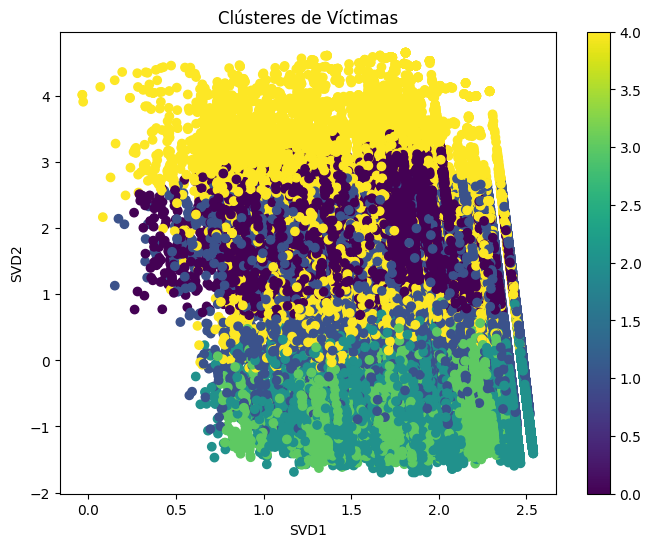

In [35]:
svd = TruncatedSVD(n_components=2)
victima_2d = svd.fit_transform(victima_preprocessed)

pca_df = pd.DataFrame(data=victima_2d, columns=['SVD1', 'SVD2'])
pca_df['cluster'] = clusters

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['SVD1'], pca_df['SVD2'], c=pca_df['cluster'], cmap='viridis')
plt.xlabel('SVD1')
plt.ylabel('SVD2')
plt.title('Clústeres de Víctimas')
plt.colorbar()
plt.show()

# Búsqueda del número óptimo de clusters

## Método del codo

In [36]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

wcss = []
for k in range(1,11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(victima_preprocessed)
  wcss.append(kmeans.inertia_)

datos_WCSS = pd.DataFrame(range(1, 11), columns = ["K"])
datos_WCSS["WCSS"] = wcss

fig = px.line(datos_WCSS, x = "K", y = "WCSS")
fig.show()

localizador_codo = KneeLocator(range(1, 11), wcss, curve = 'convex', direction = "decreasing")
print(f"\n La cantidad de clusteres debe ser {localizador_codo.elbow}")


 La cantidad de clusteres debe ser 4


# Aplicación de número óptimo de clusters

# Clustering

In [43]:
# Definir número de clústeres (k)
k = 4

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(victima_preprocessed)
clusters = kmeans.labels_

victimaDf['cluster'] = clusters

C:\Users\ealva\AppData\Local\Temp\ipykernel_1940\3791571558.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Visualización con PCA

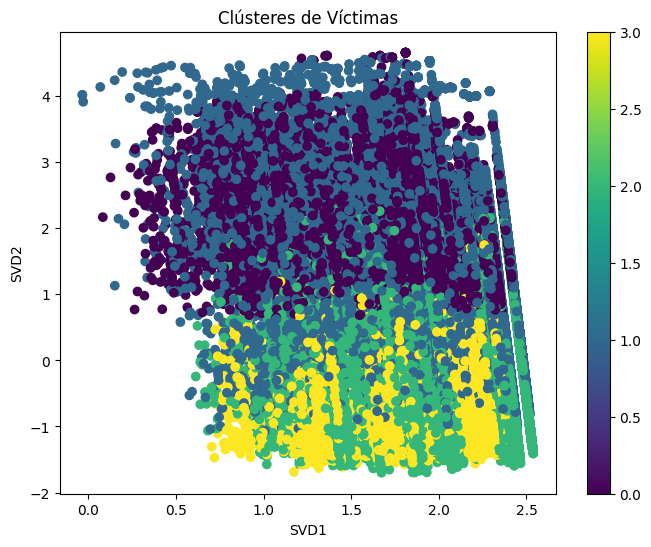

In [44]:
svd = TruncatedSVD(n_components=2)
victima_2d = svd.fit_transform(victima_preprocessed)

pca_df = pd.DataFrame(data=victima_2d, columns=['SVD1', 'SVD2'])
pca_df['cluster'] = clusters

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['SVD1'], pca_df['SVD2'], c=pca_df['cluster'], cmap='viridis')
plt.xlabel('SVD1')
plt.ylabel('SVD2')
plt.title('Clústeres de Víctimas')
plt.colorbar()
plt.show()

# Análisis de los clusters

In [59]:
columnas = ["VIC_SEXO", "VIC_EDAD", "TOTAL_HIJOS", "VIC_ALFAB", "VIC_ESCOLARIDAD", "VIC_EST_CIV", "VIC_GRUPET", "VIC_TRABAJA", "VIC_DEDICA" ,"VIC_DISC"]

## Cluster 0

In [72]:
cluster_0 = victimaDf[victimaDf['cluster'] == 0]

In [73]:
for columna in columnas:
    print(cluster_0[columna].value_counts())
    print("\n")

VIC_SEXO
Mujeres    49330
Hombres     4616
Name: count, dtype: int64


VIC_EDAD
30.0    1842
35.0    1728
32.0    1676
40.0    1621
28.0    1553
        ... 
93.0      11
91.0      11
94.0      10
95.0       7
96.0       5
Name: count, Length: 86, dtype: int64


TOTAL_HIJOS
2     10410
1     10389
3      9057
0      7233
4      6252
5      4310
6      2431
7      1575
8       971
9       495
10      369
11      161
12      121
99       89
13       45
14       16
15       13
16        5
17        3
19        1
Name: count, dtype: int64


VIC_ALFAB
No          44201
Si           9072
Ignorado      673
Name: count, dtype: int64


VIC_ESCOLARIDAD
99.0    53881
59.0       26
49.0       23
46.0        8
44.0        2
45.0        2
53.0        1
54.0        1
56.0        1
57.0        1
Name: count, dtype: int64


VIC_EST_CIV
Casados(as)     21794
Unidos(as)      15959
Solteros(as)     6910
Ignorado         6891
Otro             1483
Viudos(as)        909
Name: count, dtype: int64


VIC_GRUPE

Mayoría víctimas mujeres, las edades se centralizan en los 30 años. Un número de hijos de 0-4. La mayoría son analfabetas. La mayoría no cuenta con estudios. Mayoría casadas o unidas. Grupo étnico Maya por mayoría. La mayoría no cuenta con un trabajo o se dedica a los quehaceres del hogar. Mayoría sin discapacidad.

En resumen, podríamos decir que este grupo es de mujeres adultas jóvenes que pertenecen a comunidades mayas con familias pequeñas/medianas.

## Cluster 1

In [75]:
cluster_1 = victimaDf[victimaDf['cluster'] == 1]

In [76]:
for columna in columnas:
    print(cluster_1[columna].value_counts())
    print("\n")

VIC_SEXO
Mujeres    50196
Hombres     8636
Name: count, dtype: int64


VIC_EDAD
30.0    2102
25.0    2055
28.0    1996
23.0    1992
22.0    1959
        ... 
91.0       6
95.0       5
96.0       5
94.0       3
97.0       3
Name: count, Length: 87, dtype: int64


TOTAL_HIJOS
99    58832
Name: count, dtype: int64


VIC_ALFAB
Si          49446
No           8519
Ignorado      867
Name: count, dtype: int64


VIC_ESCOLARIDAD
99.0    14285
29.0    10802
26.0     6816
49.0     6440
39.0     4432
33.0     3341
46.0     2806
23.0     1596
22.0     1460
59.0     1386
25.0      952
45.0      874
24.0      825
32.0      701
44.0      637
31.0      472
21.0      425
55.0      197
53.0       87
56.0       86
52.0       86
51.0       61
54.0       46
57.0       19
Name: count, dtype: int64


VIC_EST_CIV
Casados(as)     21012
Ignorado        12921
Unidos(as)      12394
Solteros(as)    10897
Otro             1152
Viudos(as)        456
Name: count, dtype: int64


VIC_GRUPET
Ladinos(as)    37182
Maya     

Mayoría mujeres. Una distribución uniforme entre las edades de 20-30 años. Todas sin hijos registrados. Mayoría alfabeta. Aunque se ignoró el grado escolar de la mayoría, quienes le siguen son personas que terminaron cierto grado escolar. La mayoría son casadas. La mayoría pertenece al grupo étnico Ladino. La mayoría no trabaja. Mayoría sin discapacidad.

En resumen, podríamos decir que este grupo es de mujeres jóvenes adultas con educación y desempleadas.

## Cluster 2

In [77]:
cluster_2 = victimaDf[victimaDf['cluster'] == 2]

In [78]:
for columna in columnas:
    print(cluster_2[columna].value_counts())
    print("\n")

VIC_SEXO
Mujeres    113470
Hombres     15539
Name: count, dtype: int64


VIC_EDAD
28.0    5398
25.0    5306
30.0    5298
23.0    5276
27.0    5229
        ... 
96.0       3
93.0       3
95.0       2
94.0       2
97.0       1
Name: count, Length: 87, dtype: int64


TOTAL_HIJOS
1     38387
2     36768
3     22368
0     17040
4      8466
5      3381
6      1284
7       632
8       348
9       141
10       98
11       50
12       30
13        7
14        5
15        2
16        1
17        1
Name: count, dtype: int64


VIC_ALFAB
Si    129009
Name: count, dtype: int64


VIC_ESCOLARIDAD
26.0    22642
29.0    15449
49.0    15336
46.0    14347
33.0    13240
39.0     8347
23.0     6139
45.0     5673
22.0     4003
32.0     3814
59.0     3749
24.0     3320
25.0     2880
31.0     2551
44.0     2121
21.0     1774
55.0     1096
53.0      668
56.0      570
52.0      467
54.0      373
51.0      329
57.0      121
Name: count, dtype: int64


VIC_EST_CIV
Casados(as)     52880
Ignorado        29172
Unidos

La mayoría son mujeres. Edades concentradas en los 30 años. Numéro de hijos entre 1-3. Todas alfabetas. Todas con mínimo un año escolar alto. Mayoría casadas o unidas. Mayoría Ladinas. Mayoría hacen los quehaceres del hogar o son vendedoras no clasificadas. Mayoría sin discapacidad.

En resumen, podríamos decir que este grupo son mujeres jóvenes adultas con familias pequeñas con cierto ingreso.

## Cluster 3

In [79]:
cluster_3 = victimaDf[victimaDf['cluster'] == 3]

In [80]:
for columna in columnas:
    print(cluster_3[columna].value_counts())
    print("\n")

VIC_SEXO
Mujeres    69191
Hombres     8800
Name: count, dtype: int64


VIC_EDAD
23.0    3923
25.0    3758
22.0    3699
24.0    3589
26.0    3345
        ... 
92.0       1
97.0       1
95.0       1
90.0       1
87.0       1
Name: count, Length: 82, dtype: int64


TOTAL_HIJOS
1     23704
2     19362
0     12060
3     11991
4      5493
5      2800
6      1204
7       681
8       353
9       176
10       89
11       39
12       30
13        4
14        4
16        1
Name: count, dtype: int64


VIC_ALFAB
Si    77991
Name: count, dtype: int64


VIC_ESCOLARIDAD
26.0    18170
29.0    12018
33.0     7542
46.0     6597
23.0     6400
22.0     4215
49.0     3842
39.0     3645
24.0     3485
25.0     3037
32.0     1893
45.0     1826
21.0     1773
31.0     1360
44.0      838
59.0      465
53.0      219
55.0      210
52.0      139
56.0      116
51.0      108
54.0       74
57.0       19
Name: count, dtype: int64


VIC_EST_CIV
Casados(as)     34948
Unidos(as)      23737
Ignorado         9178
Solteros(as

Mayoría mujeres. Edades menores a 25 años. Número de hijos entre 0-2. Todas alfabetas. Mayoría casadas o unidas. Mayoría del grupo étnico Maya. Mayoría amas de casa o vendedoras. Mayoría sin discapacidad. 

En resumen, podríamos decir que este grupo son mujeres jóvenes rurales con familias pequeñas y ocupaciones variadas